In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# ARIMA: Autoregressive Integrated Moving Average

## By Team Fourier

This notebook will provide an introduction into ARIMA, short for autoregressive integrated moving average. ARIMA models aim to model time series data such as the weather, stock prices, or product sales over a period of time. The focus will be on weather data which has a seasonal aspect to it. The notebook will move into SARIMAX, short for seasonal autoregressive integrated moving average, a model that allows for seasonal periodic behavior. The notebook will rely heavily on the statsmodels Python package.

## Learning Objectives

1. Provide some insight into the power of time series analysis and moving average models as opposed to traditional function fitting techniques such as linear regression.

2. Provide a brief introduction to techniques in order to determine important characteristics of your data (stationarity, seasonality) that will influence decisions when choosing a model.

3. Give an introduction into statsmodels ARIMA and SARIMAX capabilities. In real applications, these functions are what you would use to implement an ARIMA model yourself.

4. Provide some examples of visualization, an important skill for data scientists.

5. A brief example of using grid search in order to choose optimal hyperparameters.

## Part 1: Smoothing

We can think of timeseries data as the following form:

\begin{align*}
X_{t} = m_{t} + Z_{t}
\end{align*}

This formulation of timeseries data means there is an underlying model function $m(y)$ and residuals at each observation point: $Z_{t}$. The purpose of timeseries analysis is to predict these $Z_{t}$'s using a combination of the previous $p$ or $q$ $Z_{t}$'s or the observations themselves. In this case, having an $m_{t}$ is inconvenient for our model as we only want to predict $Z_{t}$'s. Therefore, we can perform a technique called smoothing.

There are 2 main ways to perform smoothing:

1. Perform a linear or quadratic fit on the data, then simply reduce the model to $Y_{t} = X_{t} - f(t)$ which becomes $Y_{t} = Z_{t}$ if $f(t) = m_{t}$. 

2. Perform smoothing using a moving average fit.

Derive $m_{t}$ using the formula: 

\begin{align*}
m_{t} = \frac{1}{2q+1} + \sum_{j=-q}^{q} X_{t+j}
\end{align*}

Then obtain the new observations: $Y_{t} = X_{t} - m_{t}$.

### Question 1: Perform smoothing using regression

Implement smoothing using regression to find a linear or quadratic fit on the data.

In [146]:
def generate_timeseries(deg = 'linear', samples = 100):
    if deg == 'linear':
        w = np.random.uniform(2, 5)
        X = np.arange(samples).astype(np.float32)
        X *= w
    elif deg == 'quadratic':
        w = np.random.uniform(0.03, 0.08, size=(2,1))
        X = np.vstack((np.arange(samples), np.square(np.arange(samples)))).astype(np.float32).T
        X = X @ w
    elif deg == 'sinusoidal':
        period = 20
        w = np.random.uniform(50, 100)
        X = np.sin(np.arange(samples).astype(np.float32) * 2 * np.pi / period)
        X *= w
    else:
        print('only support deg = linear, quadratic, sinusoidal')
        
    X = np.random.normal(X, samples / 10)
    X = X.reshape((X.shape[0], 1))
    return X


def plot_timeseries(ts, label):
    plt.plot(ts, label=label)
    plt.xlabel('time')
    plt.ylabel('observations')


def smoothing_via_regression(X, fit="linear"):
    plot_timeseries(X, 'Timeseries Data Before Smoothing')
    
    #TODO: implement a linear or quadratic regression fit
    Y = None #output Y = X - m
    m = None #fitted model
    
    if fit == 'linear':
        time = np.arange(1, X.shape[0] + 1).reshape((X.shape[0], 1))
        w = np.linalg.lstsq(time, X)[0]
        m = time * w
        Y = X - m
        
    elif fit == 'quadratic':
        time = np.vstack((np.arange(1, X.shape[0] + 1), np.square(np.arange(1, X.shape[0] + 1)))).astype(np.float32).T
        w = np.linalg.lstsq(time, X)[0]
        m = time @ w
        Y = X - m
    else:
        print('fit must be one of "linear" or "quadratic"')
        
    plot_timeseries(Y, 'Timeseries Data After Model Fit')
    plot_timeseries(m, 'Fitted Model')
    plt.legend()
    plt.title("Smoothing using %s regression" % fit)
    plt.show()


### Question 2: Perform smoothing using moving average

Implement smoothing using a moving average to approximate $m_{t}$.

In [180]:
def smoothing_via_moving_average(X, q=1):
    plot_timeseries(X, 'Timeseries Data Before Smoothing')
    
    assert(X.shape[0] > 2 * q + 1)
    
    #TODO: implement a moving average fit using the parameter q
    #try using np.convolve(mode="same"), don't worry about weird values on the boundaries
    Y = None #output Y = X - m
    m = None #fitted model
    
    m = np.convolve(X.reshape(X.shape[0]), np.ones(2*q + 1), mode="same")
    m = m.reshape((m.shape[0], 1))
    m /= (2 * q + 1)
    Y = X - m
        
    plot_timeseries(Y, 'Timeseries Data After Model Fit')
    plot_timeseries(m, 'Fitted Model')
    plt.legend()
    plt.title("Smoothing using moving average with parameter q=%d" % q)
    plt.show()
    

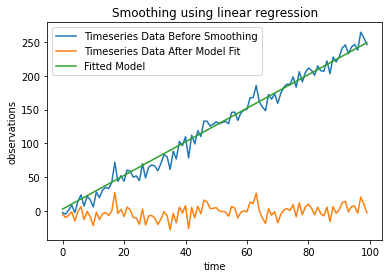

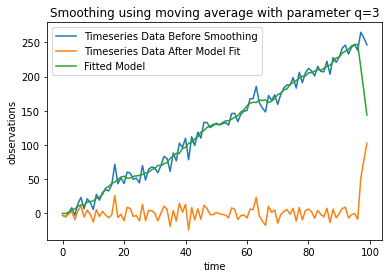

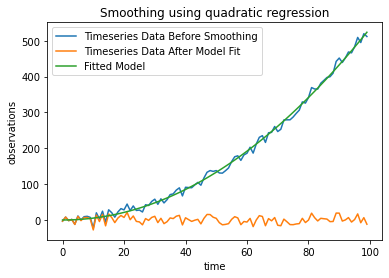

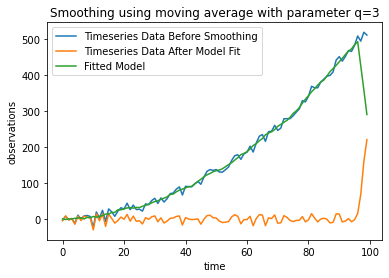

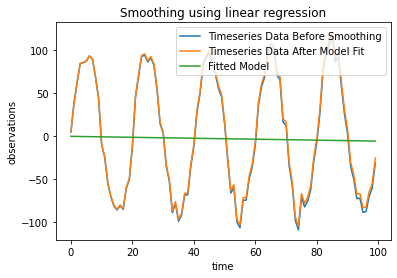

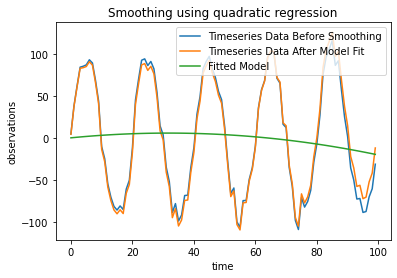

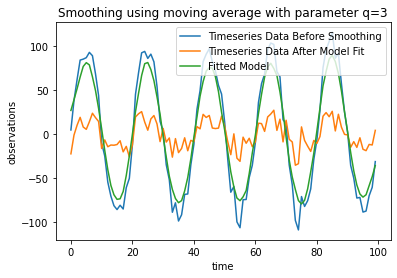

In [181]:
X_linear = generate_timeseries(deg='linear')
smoothing_via_regression(X_linear, fit='linear')
smoothing_via_moving_average(X_linear, q=3)


X_quad = generate_timeseries(deg='quadratic')
smoothing_via_regression(X_quad, fit='quadratic')
smoothing_via_moving_average(X_quad, q=3)

X_sin = generate_timeseries(deg='sinusoidal')
smoothing_via_regression(X_sin, fit='linear')
smoothing_via_regression(X_sin, fit='quadratic')
smoothing_via_moving_average(X_sin, q=3)

### Question 3: Test Smoothing on a Real Dataset

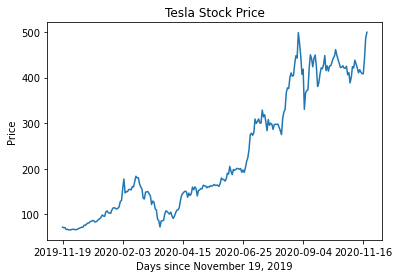

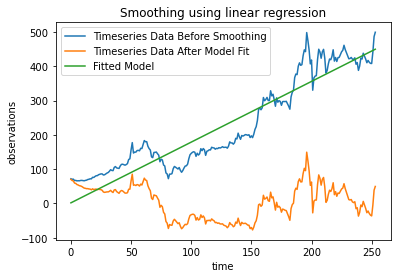

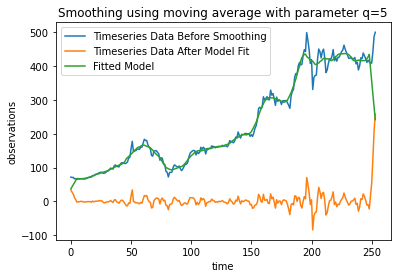

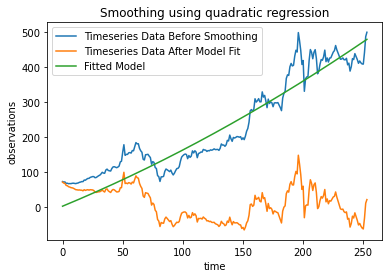

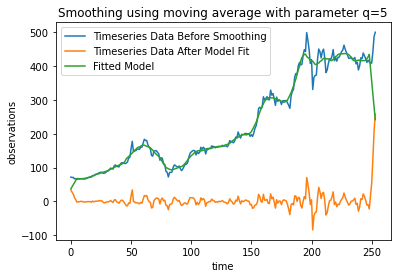

In [148]:
data = pd.read_csv('data/TSLA.csv')
time = np.array(data['Date'])
price = np.array(data['Close'])

plt.title('Tesla Stock Price')
plt.plot(time, price)
plt.xticks(time[::50])
plt.xlabel('Days since November 19, 2019')
plt.ylabel('Price')
plt.show()

price = price.reshape((price.shape[0], 1))

smoothing_via_regression(price, fit='linear')
smoothing_via_moving_average(price, q=5)
smoothing_via_regression(price, fit='quadratic')
smoothing_via_moving_average(price, q=5)

### Observations:
1. Which smoothing performed better using the synthetic data?

<span style="color:blue">The linear and quadratic fit smoothing worked very well on the linear and quadratic synthetic data. Obviously, if the underlying observations follow a linear or quadratic model, then using a linear or quadratic approximation will retrieve the true underlying model. However, on sinusoidal data, both linear and quadratic fits drastically fail as the sinusoidal data can't be approximated using a linear or quadratic function. Here, the moving average performed much better. In general, the moving average worked the most consistently.</span>

2. Which smoothing performed better using the real Tesla data? Why?

<span style="color:blue">The moving average smoothing worked the best on the Tesla data as there are changing trend levels, meaning at some points the data has a strong trend, and at others not so strong a trend. This piecewise-ness means any attempt at a linear or quadratic fit fails.</span>

3. Try using different values of q, what happens when the value of q becomes very large. What happens when it is too small?

<span style="color:blue">When q is very large, this is oversmoothed and the bias becomes very large. When q is very small, this is undersmoothed, note: when q=0, this is the same as no smoothing at all.</span>

## Part 2: Stationarity and Differencing

Smoothing is one way to enforce stationarity on the timeseries data. What is stationarity?  
Stationarity is the idea that the data is the same no matter where you look. Formally, that is the following equation is the same for the joint distributions given any $t$, $q$, $n$:

\begin{align*}
P(X_{t}, ..., X_{t+n}) = P(X_{q}, ..., X_{q+n})
\end{align*}

For data, you can assess this qualitatively: No obvious trend, and no seasonality. If the data, however, has some sort of trend or seasonality, we can get rid of them via differencing.

### Question 1: Trend Differencing

If our data has a trend, meaning it can be expressed as:

\begin{align*}
X_{t} = m_{t} + Z_{t}
\end{align*}

Differencing is a technique in which we can create a new timeseries:

\begin{align*}
Y_{t} = X_{t} - X_{t-1}
\end{align*}

If our trend is linear, for instance, we can achieve the following result using differencing:

\begin{align*}
m_{t} = at + b\\
X_{t} = m_{t} + Z_{t}\\
X_{t-1} = m_{t-1} + Z_{t-1}\\
Y = X_{t} - X_{t-1} = a + Z_{t} - Z_{t-1}
\end{align*}

We see that in this case, the trend has been completely removed, $at$.

Perform differencing to eliminate the trend from the timeseries.

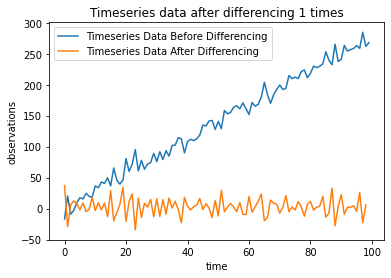

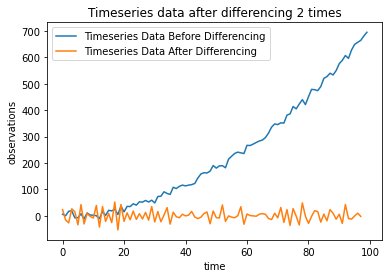

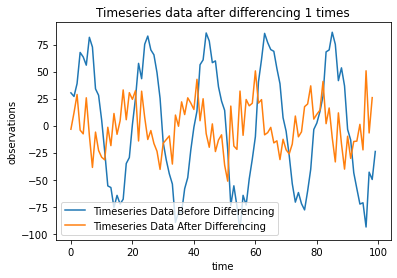

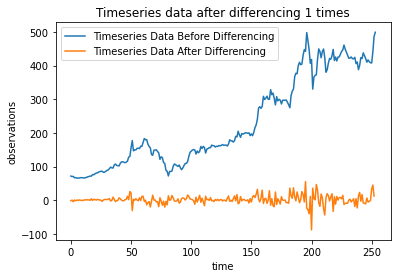

In [149]:
def trend_removal_via_differencing(X, diff=1):
    plot_timeseries(X, 'Timeseries Data Before Differencing')
    
    #TODO: implement regular differencing with diff=diff
    Y = None #output Y = X - m
    
    Y = X[1:] - X[:-1]
    for i in range(diff - 1):
        Y = Y[1:] - Y[:-1]
        
    plot_timeseries(Y, 'Timeseries Data After Differencing')
    plt.legend()
    plt.title("Timeseries data after differencing %d times" % diff)
    plt.show()
    
    
X_linear_trend = generate_timeseries(deg='linear')
X_quad_trend = generate_timeseries(deg='quadratic')
X_sin_trend = generate_timeseries(deg='sinusoidal')

trend_removal_via_differencing(X_linear_trend)
trend_removal_via_differencing(X_quad_trend, diff = 2)
trend_removal_via_differencing(X_sin_trend, diff=1)

#using differencing on Tesla data
trend_removal_via_differencing(price)

### Observations:

1. Which data did differencing perform well on?

<span style="color:blue">Differencing performed best on data with a single trend, such as a linear or quadratic function.</span>

2. Which data did differencing perform poorly on?

<span style="color:blue">Differencing performed poorly on the sinusoidal data as it does not have a consistent trend throughout the entire timeseries. Instead, at some points, the derivative of the data is much higher than at other points.</span>

3. For linear data, what level of differencing should be used?

<span style="color:blue">As derived in the start of this part, for linear data, differencing once should remove the trend.</span>

4. For quadratic data, what level of differencing should be used? (Try the math)

<span style="color:blue">For quadratic data, we should perform differencing twice.

$X_{t} = at^{2}$  
$X_{t-1} = a(t-1)^{2}$  
$X_{t} - X{t-1} = at^{2} - at^{2} + 2at - a = 2at - a$  
$X_{t} - X{t-1} - (X_{t-1} - X_{t-2}) = 2at - a - (2a(t-1) - a) = 2$  

</span>

### Question 2: Seasonal Differencing

You probably saw that differencing performed poorly on some of the data because it had a seasonal trend.

If our data has a seasonal trend, meaning it can be expressed as:

\begin{align*}
X_{t} = m_{t} + Z_{t}\\
m_{t} = m_{t-p}
\end{align*}

where $p$ is the period of the seasonal trend.

Seasonal differencing is a technique in which we can create a new timeseries:

\begin{align*}
Y_{t} = X_{t} - X_{t-p}
\end{align*}

If our trend is linear, for instance, we can achieve the following result using differencing:

\begin{align*}
m_{t} = m_{t-p}\\
X_{t} = m_{t} + Z_{t}\\
X_{t-p} = m_{t-p} + Z_{t-p}\\
Y = X_{t} - X_{t-p} = Z_{t} - Z_{t-p}
\end{align*}

We see that in this case, the trend has been completely removed by using the property of our trend's seasonality.

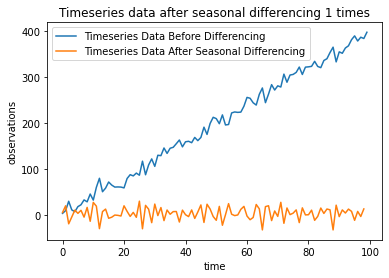

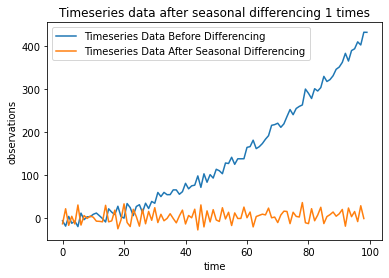

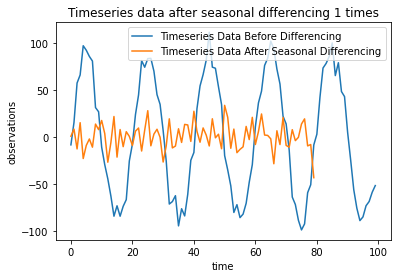

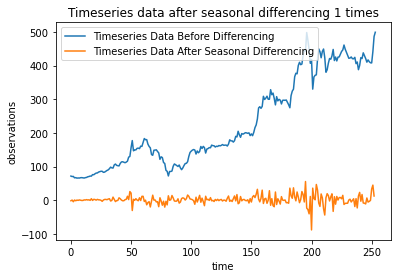

In [150]:
def trend_removal_via_seasonal_differencing(X, diff=1, period = 1):
    plot_timeseries(X, 'Timeseries Data Before Differencing')
    
    #TODO: implement seasonal differencing with diff=diff, period=period
    Y = None
    
    Y = X[period:] - X[:-period]
    for i in range(diff - 1):
        Y = Y[period:] - Y[:-period]
        
    plot_timeseries(Y, 'Timeseries Data After Seasonal Differencing')
    plt.legend()
    plt.title("Timeseries data after seasonal differencing %d times" % diff)
    plt.show()
    
    
X_linear_trend = generate_timeseries(deg='linear')
X_quad_trend = generate_timeseries(deg='quadratic')
X_sin_trend = generate_timeseries(deg='sinusoidal')

trend_removal_via_seasonal_differencing(X_linear_trend)
trend_removal_via_seasonal_differencing(X_quad_trend)
trend_removal_via_seasonal_differencing(X_sin_trend, period=20)

#using differencing on Tesla data
trend_removal_via_seasonal_differencing(price)

### Observations:
1. Did the timeseries that trend differencing failed on work with seasonal differencing? With what parameter period?

<span style="color:blue">Yes, with period = 20, the seasonal differencing worked very well on the sinuosoidal data.</span>

2. How does seasonal differencing work on linear/quadratic data? Derive what seasonal differencing does to data that is not actually seasonal. You should see that it effectively removes the trend while introducing more bias.

<span style="color:blue">The seasonal differencing still seems to successfully get rid of the trend effectively. If there is a linear trend, we can see from the derivation that the trend is still removed from $Y_{t}$ but the amount of bias added is linearly proportial to the period of the seasonal differencing.</span>

### Question 3:

Performing both seasonal and trend differencing on data can remove both seasonal and non-seasonal trends.

If our data has a seasonal and non-seasonal trend, meaning it can be expressed as:

\begin{align*}
X_{t} = m_{t} + s_{t} + Z_{t}\\
s_{t} = s_{t-p}
\end{align*}

where $p$ is the period of the seasonal trend. $m_{t}$ is the non-seasonal trend.

Combining both seasonal and non-seasonal differencing is a technique in which we can create a new timeseries:  
First, seasonal differencing:
\begin{align*}
Y_{t} = m_{t} - m_{t-p} + Z_{t} - Z_{t-p}
\end{align*}

Then, regular differencing:
\begin{align*}
Y_{t} = m_{t} - m_{t-p} + Z_{t} - Z_{t-p}\\
Y_{t-1} = m_{t-1} - m_{t-p-1} + Z_{t-1} - Z_{t-p-1}\\
Y_{t} - Y_{t-1} = c + Z_{t} - Z_{t-p} + Z_{t-1} - Z_{t-p-1}
\end{align*}

We see that by performing first seasonal differencing, and then regular differencing, we can remove both a seasonal and trend component from the data.

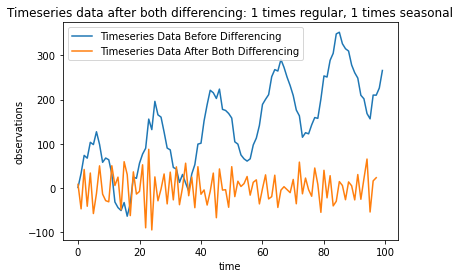

In [151]:
def trend_removal_via_seasonal_nonseasonal_differencing(X, diff=1, period = 1, seasonal_diff=1):
    plot_timeseries(X, 'Timeseries Data Before Differencing')
    
    #TODO: 
    Y = X[period:] - X[:-period]
    for i in range(seasonal_diff - 1):
        Y = Y[period:] - Y[:-period]
        
    for i in range(diff):
        Y = Y[1:] - Y[:-1]
        
        
    plot_timeseries(Y, 'Timeseries Data After Both Differencing')
    plt.legend()
    plt.title("Timeseries data after both differencing: %d times regular, %d times seasonal" % (diff, seasonal_diff))
    plt.show() 
    
X_linear_trend = generate_timeseries(deg='linear')
X_seasonal_trend = generate_timeseries(deg='sinusoidal')

X_both = X_linear_trend + X_seasonal_trend

trend_removal_via_seasonal_nonseasonal_differencing(X_both)

### Observations
1. Did it work? Does the data now look stationary, there is no underlying direction to the data?

<span style="color:blue">Yes. The data now looks stationary.</span>

## Part 3: ARIMA using statsmodels

In [78]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX

import datetime as dt

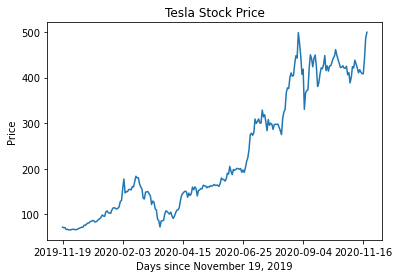

In [153]:
data = pd.read_csv('data/TSLA.csv')
time = np.array(data['Date'])
price = np.array(data['Close'])

plt.title('Tesla Stock Price')
plt.plot(time, price)
plt.xticks(time[::50])
plt.xlabel('Days since November 19, 2019')
plt.ylabel('Price')
plt.show()

The graph above depicts the stock price of TSLA over time. The x-axis being time and the y-axis being f(t), the price at that point in time.

Clearly a basic linear model wouldn't be able to model such a function of time due to its non-linearity. However, we have previously learned ways to fit non-linear functions with linear regression using feature lifting. Maybe lifting some polynomial features might help?

### Trying Linear Regression

Linear features, linear regression

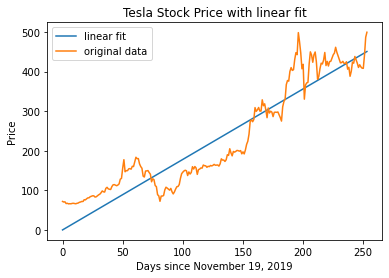

In [154]:
time_steps = np.arange(0, time.shape[0], 1).astype(np.int).reshape((time.shape[0], 1))

#TODO: run a least squares linear regression in the format Ax=b, A = time_steps, B = price
#place the result in w
#Hint: try np.linalg.lstsq
w = np.linalg.lstsq(time_steps, price)[0]

plt.plot(time_steps, w * time_steps, label='linear fit')
plt.plot(time_steps, price, label = 'original data')
plt.legend()
plt.title('Tesla Stock Price with linear fit')
plt.xlabel('Days since November 19, 2019')
plt.ylabel('Price')
plt.show()


Polynomial features, linear regression

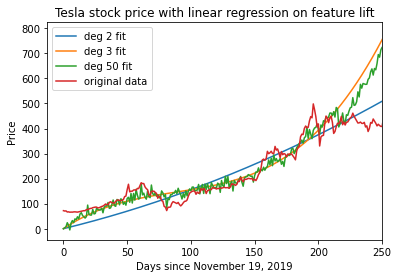

Training error with degree 2 features: [486889.1676851]
Training error with degree 3 features: [292701.38673616]
Training error with degree 50 features: [221481.69154718]


In [155]:
def feature_lift(X, d=2):
    """
    This function computes second order variables
    for polynomial regression.
    Input:
    X: Independent variables.
    Output:
    A data matrix composed of both first and second order terms.
    """
    
    X = np.array(X)
    
    X_data = []
    
    for deg in range(1, d+1):
        X_data.append(np.power(X, deg))
        
    return np.hstack(X_data)

second_order_time_steps = feature_lift(time_steps, d=2)
w_2, err_2, _, _ = np.linalg.lstsq(second_order_time_steps[:210], price[:210])

third_order_time_steps = feature_lift(time_steps, d=3)
w_3, err_3, _, _ = np.linalg.lstsq(third_order_time_steps[:220], price[:220])

fifty_order_time_steps = feature_lift(time_steps, d=50)
w_50, err_50, _, _ = np.linalg.lstsq(fifty_order_time_steps[:220], price[:220])

plt.plot(time_steps, second_order_time_steps @ w_2.T, label='deg 2 fit')
plt.plot(time_steps, third_order_time_steps @ w_3.T, label='deg 3 fit')
plt.plot(time_steps, fifty_order_time_steps @ w_50.T, label='deg 50 fit')
plt.plot(time_steps, price, label = 'original data')

plt.xlim(right=250)
plt.xlabel('Days since November 19, 2019')
plt.ylabel('Price')
plt.legend()
plt.title('Tesla stock price with linear regression on feature lift')
plt.show()

print('Training error with degree 2 features: %s' % str(err_2))
print('Training error with degree 3 features: %s' % str(err_3))
print('Training error with degree 50 features: %s' % str(err_50))

Basically, any attempt to fit some sort of function using linear regression and feature lifting will be met with failure. Why? This is due to the nature of time series data. The problem that linear regressions try to solve is fitting some function to the data in its entirety. However, time series data, such as stock prices don't operate under the same assumptions. Does the stock price 1 year ago directly affect the stock price tomorrow? The answer is, not really. This understanding that only the previous n' << n observations are truly important to our model spawns this set of models that utilize the moving average, the first MA model, then the ARMA, and ARIMA models.

### Formulation of the ARIMA Model

The mathematical model behind ARIMA is:

\begin{align*}
ARIMA(p, d, q) = (1 - \phi_{1}L - \phi_{2}L^{2} - \phi_{3}L^{3}... - \phi_{p}L^{p}) (1 - L)^{d} y_{t} = c + (1 + \theta_{1} L + \theta_{2} L^{2}... + \theta_{q} L^{q}) \epsilon_{t}
\end{align*}

The L is the lag operator, $L^d y_{t} = y_{t - d}$.

The first group of terms, containing $\phi$'s, are the auto-regressive terms. Auto-regressive refers to the contribution of previous observations on the current observation. The parameter $p$ is the number of previous observations looked at. The $\phi$'s are their individual weighting. Intuitively, an observation 1 time step ago usually holds more weight than an observation 10 time steps ago.

The second term, $(1 - L)^{d}$, is the integrated term. This is the term that implements the idea of differencing, which is sometimes necessary to find a deeper relationship in the data. The time series function may not be able to model the observation themselves, but may be able to model the difference between successive observations.

The third and final term, containing $\theta$'s, represent the moving average portion of the model. This is the contribution of the previous $q$ terms, specifically their residuals to the residual at time t. The residuals, $\epsilon_{t}$, are standard normal distribution deviations of each observation from the predicted observation predicted by the model. These residuals are what we try to minimize when fitting parameters to the training data.

The constant c quantifies the drift of the model.

## Breaking Down the ARIMA Model

### Auto-Regressive (AR)

One of the fundamental building blocks of the ARIMA model is the AR portion of the model. The equation for a simple AR model is:

\begin{align*}
AR(p) = y_{t} = c + (\phi_{1}L + \phi_{2}L^{2} + \phi_{3}L^{3}... + \phi_{p}L^{p})y_{t} + \epsilon_{t}
\end{align*}

This equation can already begin to model functions under the assumption that current observations are simply derived from a linear combination of the p previous observations.



For the rest of this part of the notebook, we'll be working with weather data instead of stock data.

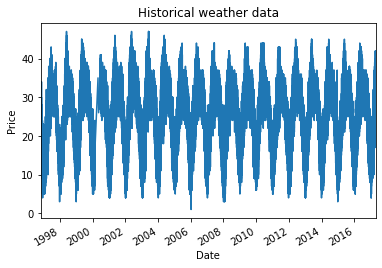

datetime_utc
1996-11-01 11:00:00    30.0
1996-11-01 12:00:00    28.0
1996-11-01 13:00:00    24.0
1996-11-01 14:00:00    24.0
1996-11-01 16:00:00    23.0
Name: temperature, dtype: float64
Null values: 0


In [20]:
#load dataset
weather_data = pd.read_csv('data/weather_data.csv', parse_dates=['datetime_utc'], index_col='datetime_utc')
weather_data = weather_data.rename(index=str, columns={' _tempm': 'temperature'})

#interpolate null values
weather_data.ffill(inplace=True)
weather_data.index = pd.to_datetime(weather_data.index)

#remove outliers
weather_data = weather_data[weather_data.temperature < 50]
weather_temp = weather_data['temperature']

weather_temp.plot()
plt.xlabel('time')
plt.ylabel('temp in deg C')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Historical weather data')
plt.show()

print(weather_temp.head())
print('Null values: %s' % str(weather_temp.isnull().sum()))

The first thing we do with our data is clean it, interpolating null values and making sure the samples are evenly spaced. Next, there are some things we can check about the data itself to ensure it is suitable for an ARIMA model.

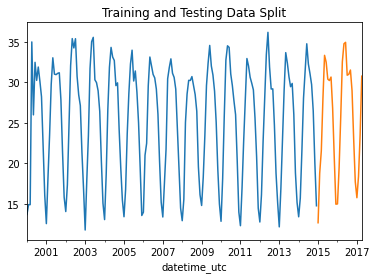

In [23]:
training_data = weather_temp['2000':'2014'].resample('M').mean().fillna(method='pad')
testing_data = weather_temp['2015':'2017'].resample('M').mean().fillna(method='pad')
training_data.plot()
testing_data.plot()
plt.title('Training and Testing Data Split')
plt.show()

In the next cell we will plot the autocorrelation of both the original data and the differences between consecutive data points. There is also a provided function ``plot_rolling_mean_std``. Try to find a period length that creates a constant rolling mean. What does this say about the periodicity of the data?

<span style="color:blue">The period length should be 12. This says the data has a periodicty of 12. This makes sense as weather follows an annual cycle, 12 months.</span>

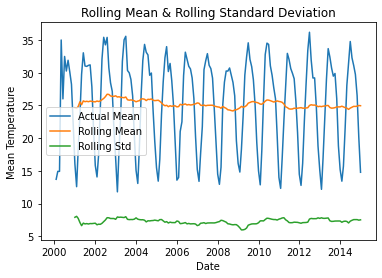

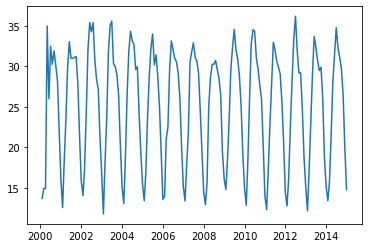

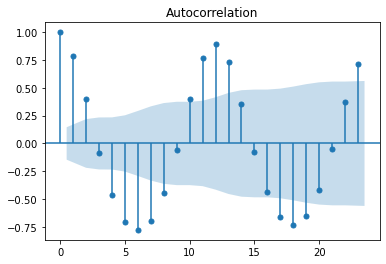

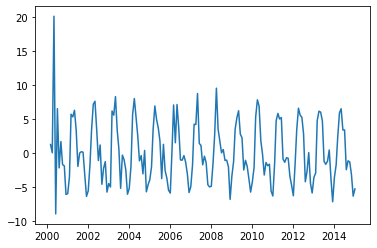

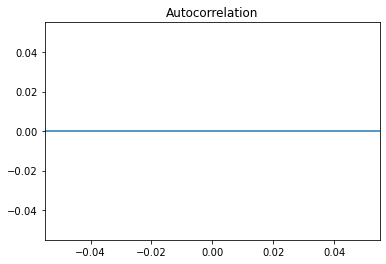

In [158]:
# check rolling mean and rolling standard deviation
def plot_rolling_mean_std(ts, period):
    rolling_mean = ts.rolling(period).mean()
    rolling_std = ts.rolling(period).std()

    plt.plot(ts, label='Actual Mean')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.legend()
    plt.show()

#TODO: change this period parameter until the resulting rolling mean is 0 (Hint: What do you think the period of this data is?)
plot_rolling_mean_std(training_data, period = 12)
    
plt.plot(training_data)
plot_acf(training_data)
plt.show()

plt.plot(training_data.diff())
plot_acf(training_data.diff().values)
plt.show()


We see from the rolling mean and rolling standard deviation plot that the data has a constant mean and standard deviation on a 12 month period. This periodicity implies that our data is seasonal, meaning a standard ARIMA model will have trouble fitting it, but instead we will need to use the seasonal aspect of SARIMA to fit the data.

First, we will try to see what kind of model we retrieve from an AR model.

In [80]:
def process_result(res, model='arima'):
    print(res.summary())
    
    plt.plot(res.resid)
    plt.title('Training Residuals')
    plt.xlabel('Months')
    plt.ylabel('Temperature in C')
    plt.show()

    print('Mean squared training error: %s' % str(np.square(res.resid).mean()))

    plt.plot(res.predict(), label='Prediction')
    plt.plot(training_data.values, label='Real values')
    plt.legend()
    plt.title('Model fit on training data')
    plt.xlabel('Months')
    plt.ylabel('Temperature in C')
    plt.show()
    
    if model == 'arima':
        fc, se, conf = res.forecast(testing_data.shape[0], alpha=0.05)
    elif model == 'sarimax':
        fc = res.forecast(testing_data.shape[0], alpha=0.05)
        
    fc_series = pd.Series(fc, index=testing_data.index)
    plt.plot(fc_series, label='Prediction')
    plt.plot(testing_data, label='Real values')
    plt.legend()
    plt.title('Model prediction on test data')
    plt.xlabel('Datetime')
    plt.ylabel('Temperature in C')
    plt.show()
    
    #TODO: Calculate the mean squared testing error
    squared_testing_error = np.square(fc - testing_data).mean()
    print('Mean squared testing error: %s' % str(squared_testing_error))
    

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  180
Model:                     ARMA(4, 0)   Log Likelihood                -443.169
Method:                       css-mle   S.D. of innovations              2.815
Date:                Fri, 27 Nov 2020   AIC                            898.338
Time:                        16:18:54   BIC                            917.495
Sample:                             0   HQIC                           906.105
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.1769      0.412     61.128      0.000      24.370      25.984
ar.L1.y        0.9763      0.075     13.051      0.000       0.830       1.123
ar.L2.y        0.0084      0.099      0.085      0.9

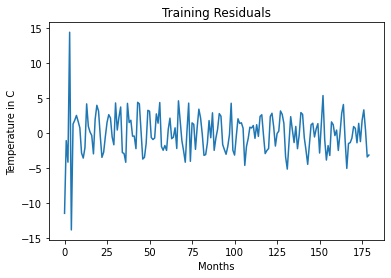

Mean squared training error: 8.569417315817905


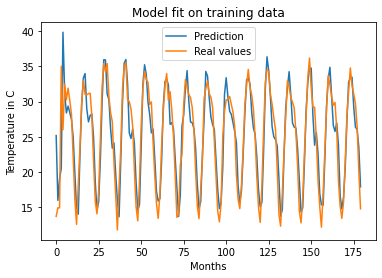

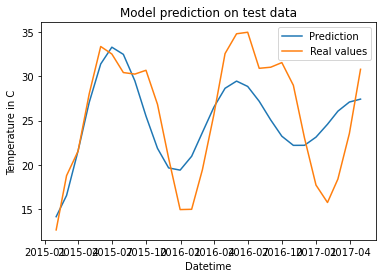

Mean squared testing error: 20.6343968590941


In [161]:
#use ARIMA(data, order).fit() to generate an AR model fit using order=(p, 0, 0)
#Hint: try p > 1
res = ARIMA(training_data.values, order=(4, 0, 0)).fit()
process_result(res)


### Write down your observations.

How does the model perform on the training data?

<span style="color:blue">The model performs quite well on the training data and seems to fit the data well.</span>

How does the model perform on the forecasting of future data?

<span style="color:blue">The model does not fit the testing data as well as the training data but still seems to output a model that recognizes the overall shape of the weather data. </span>

Why does the AR model not fit this seasonal data well?

<span style="color:blue">The AR model has no seasonal terms and can't be used to fully describe weather data.</span>

### Moving Average (MA)

Another fundamental building block of the ARIMA model is the MA portion of the model. The equation for a simple MA model is:

\begin{align*}
MA(q) = y_{t} = c + \epsilon_{t} + \theta_{1}\epsilon_{t-1} + \theta_{2}\epsilon_{t-2} + ... + \theta_{q}\epsilon_{t-q}
\end{align*}

This equation models the assumption that the residual, the deviation from the predicted point, of the current observation is a linear combination of the previous q residuals.

Add the moving average section of the ARIMA model, and model the weather data using an ARMA model.

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  180
Model:                     ARMA(2, 2)   Log Likelihood                -427.374
Method:                       css-mle   S.D. of innovations              2.570
Date:                Fri, 27 Nov 2020   AIC                            866.747
Time:                        16:18:56   BIC                            885.905
Sample:                             0   HQIC                           874.515
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.2027      0.126    199.485      0.000      24.955      25.450
ar.L1.y        1.6794      0.025     68.178      0.000       1.631       1.728
ar.L2.y       -0.9528      0.024    -40.304      0.0

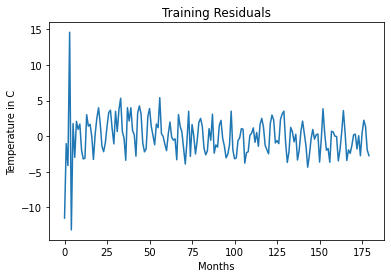

Mean squared training error: 7.649049707253839


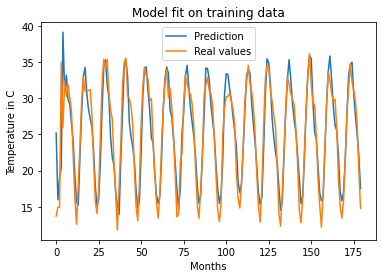

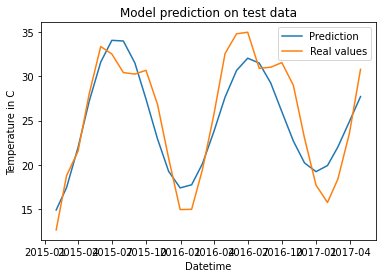

Mean squared testing error: 8.853190571694395


In [162]:
#use ARIMA(data, order).fit() to generate an ARMA model fit using order=(p, 0, q)
#Hint: try p, q > 1
res = ARIMA(training_data.values, order=(2, 0, 2)).fit()
process_result(res)

### Write down your observations.

How does the model perform on the training data?

<span style="color:blue">The model once again performs pretty well on the training data. Better than simply the AR model.</span>

How does the model perform on the forecasting of future data?

<span style="color:blue">The model fits the testing data better than the AR model as well. This is because our model is more expressive and able to more accurately describe the true time series data.</span>

Does the ARMA model fit the seasonal data better than the AR model?

<span style="color:blue">Yes. By being more expressive it naturally can describe the seasonal data better.</span>

## Seasonality in ARIMA: SARIMA

As we noted in the weather data, we see a seasonal pattern, or period with fixed period length. The traditional ARIMA model is not fully suited to model this behavior, but this is where SARIMA comes into play. SARIMA, season auto-regressive integrated moving average, has a slightly different formulation from ARIMA:

\begin{align*}
SARIMA(p, d, q) (P, D, Q)_{m} = (1 - \phi_{1}L - \phi_{2}L^{2} - \phi_{3}L^{3}... - \phi_{p}L^{p}) (1 - \Phi_{1}L^{m} - \Phi_{2}L^{2m} - \Phi_{3}L^{3m}... - \Phi_{P}L^{Pm}) (1 - L)^{d} (1 - L)^{Dm} y_{t} = c + (1 + \theta_{1} L + \theta_{2} L^{2}... + \theta_{q} L^{q}) (1 + \Theta_{1} L^{m} + \Theta_{2} L^{2m}... + \Theta_{Q} L^{Qm}) \epsilon_{t}
\end{align*}

The seasonal terms are terms that operate much like the original ARIMA terms, but the lag operators are all raised to the power of $m$, in the case of the annual cycle of weather data, $m=12$, meaning the model takes into account observations from 12, 24, 36.... months ago.

Implement a SARIMA model on the weather data.

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  180
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 12)   Log Likelihood                -389.026
Date:                             Fri, 27 Nov 2020   AIC                            790.052
Time:                                     16:18:59   BIC                            809.210
Sample:                                          0   HQIC                           797.820
                                             - 180                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0313      0.023      1.347      0.178      -0.014       0.077
ar.L2          0.9685      

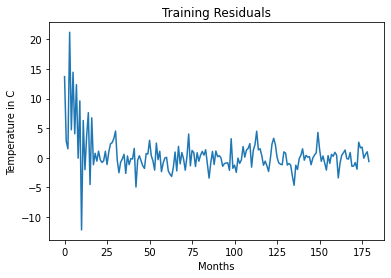

Mean squared training error: 10.607873349210044


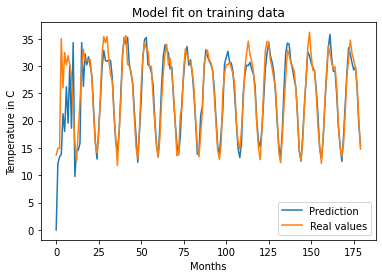

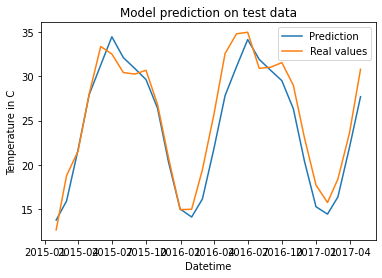

Mean squared testing error: 4.594738756786617


In [163]:
res = SARIMAX(training_data.values, order=(2, 0, 2), seasonal_order=(1, 0, 0, 12)).fit()
process_result(res, 'sarimax')

### Write down your observations.

How does the model perform on the training data?

<span style="color:blue">The model performs better on the training data than any of the previous models. This is because the true underlying time series data has a seasonal component that our model can now express.</span>

How does the model perform on the forecasting of future data?

<span style="color:blue">It performs much better than previous attempts using just ARMA.</span>

Does the SARIMAX model fit the seasonal data better than the ARIMA model?

<span style="color:blue">Yes.</span>

## Part 4: Evaluating your ARIMA model

### Hyperparameters

You may have noticed that sometimes the performance is better than other times when using different values for p, d, q, P, D, and Q. These values are called hyperparameters, hand selected values by the engineer creating the model that greatly influence the effectiveness of the model. There are several ways to set these hyperparameters, as discussed earlier in this course. You can employ techniques such as k-fold cross validation and grid searches, as well as use domain knowledge to make educated guesses on what we want the model to learn and what the underlying model in reality is. For example, someone with strong knowledge of the weather can make a better educated guess about how many days one should look back in the past to predict today's weather.

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  180
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 12)   Log Likelihood                -366.885
Date:                            Fri, 27 Nov 2020   AIC                            751.771
Time:                                    16:19:03   BIC                            780.507
Sample:                                         0   HQIC                           763.422
                                            - 180                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7397      0.173      4.281      0.000       0.401       1.078
ar.L2          0.2431      0.171   

c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


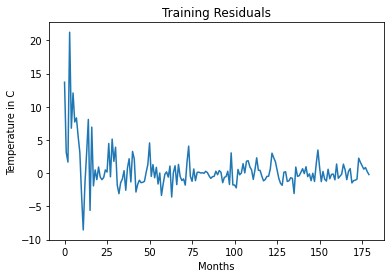

Mean squared training error: 8.96511692974023


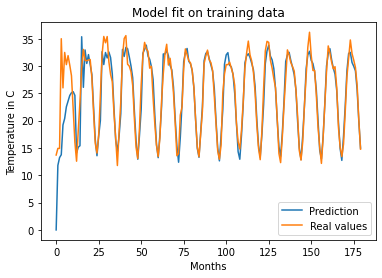

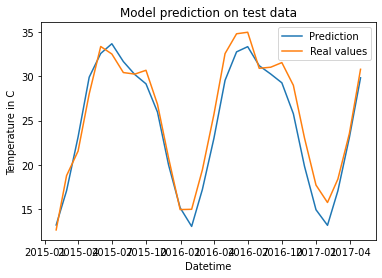

Mean squared testing error: 3.2735343012303146


In [164]:
#TODO run a SARIMAX model with your guess
res = SARIMAX(training_data.values, order=(2, 0, 2), seasonal_order=(2, 0, 2, 12)).fit()
process_result(res, 'sarimax')

Now, let's try using a grid search to find the best parameters.

c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihoo

Best parameters:  (1, 1, 2, 1)  Best Test MSE:  3.215760089183476
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  180
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 12)   Log Likelihood                -367.479
Date:                            Fri, 27 Nov 2020   AIC                            746.958
Time:                                    16:31:44   BIC                            766.116
Sample:                                         0   HQIC                           754.726
                                            - 180                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9839      0.054     18.288     

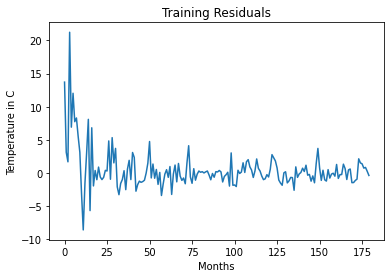

Mean squared training error: 8.98073705845994


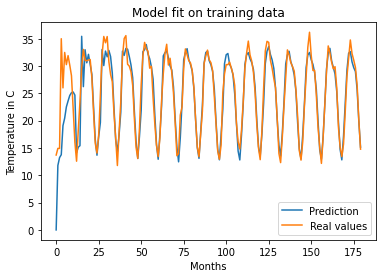

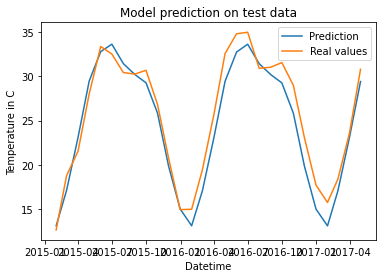

Mean squared testing error: 3.215760089183476


In [177]:
def get_test_mse(res):
   #todo calculate test mse  
    fc = res.forecast(testing_data.shape[0], alpha=0.05)
    squared_testing_error = np.square(fc - testing_data).mean()
    return squared_testing_error

p_range = list(range(3))
q_range = list(range(3))
P_range = list(range(3))
Q_range = list(range(3))

best_params = (-1, -1, -1, -1)
best_test_mse = 10000000

#todo use a grid search to find the best parameters
for p in p_range:
    for q in q_range:
        for P in P_range:
            for Q in Q_range:
                try:
                    res = SARIMAX(training_data.values, order=(p, 0, q), seasonal_order=(P, 0, Q, 12), maxiter = 5).fit()
                    test_mse = get_test_mse(res)
                    if test_mse < best_test_mse:
                        best_params = (p, q, P, Q)
                        best_test_mse = test_mse
                except:
                    pass
                
                
print('Best parameters: ', best_params, ' Best Test MSE: ', best_test_mse)
res = SARIMAX(training_data.values, order=(best_params[0], 0, best_params[1]), seasonal_order=(best_params[2], 0, best_params[3], 12)).fit()
process_result(res, 'sarimax')

That probably took a while, was it worth it?

### Observations

How did the grid search perform compared to your guess?

<span style="color:blue">The grid search performed better than my guess.</span>

### Evaluating our Model: AIC

Not only do we need to tune the hyperparameters to increase the performance of our model, but we also need a way to evaluate our model. We need a measure that maximizes the accuracy of the model while minimizing the number of parameters of our model, to avoid overfitting our training data. This is where AIC comes in. AIC is short for Akaike information criterion. It is formulated as follows:

\begin{align*}
AIC = -2log(L) + 2(p + q + k)
\end{align*}

k = 1 if the model includes an intercept, else k = 0.  
L = likelihood of our data (this depends on the residuals and dist. of white noise)

We want our model to minimize this quantity.  
Intuitively, we want to maximize the likelihiood of our data while our model is penalized by the complexity of the data.

Perform the grid search again on the hyperparameters while instead minimizing AIC instead of test_mse.

c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\users\adam2\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Best parameters:  (1, 1, 1, 1)  Best AIC:  744.9928707697925
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  180
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -367.496
Date:                            Fri, 27 Nov 2020   AIC                            744.993
Time:                                    16:34:09   BIC                            760.958
Sample:                                         0   HQIC                           751.466
                                            - 180                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9846      0.024     40.513      0.00

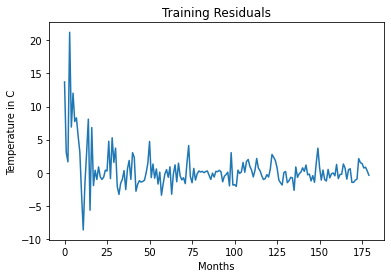

Mean squared training error: 8.962339128586427


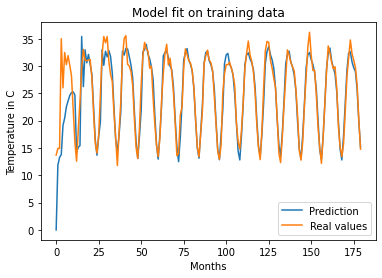

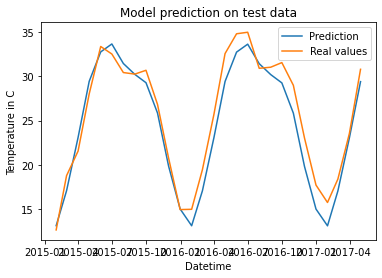

Mean squared testing error: 3.2216796724759535


In [178]:
p_range = list(range(3))
q_range = list(range(3))
P_range = list(range(2))
Q_range = list(range(2))

best_params = (-1, -1, -1, -1)
best_aic = 10000000

#todo use a grid search to find the best parameters
for p in p_range:
    for q in q_range:
        for P in P_range:
            for Q in Q_range:
                try:
                    res = SARIMAX(training_data.values, order=(p, 0, q), seasonal_order=(P, 0, Q, 12), maxiter = 5).fit()
                    aic = res.aic
                    if aic < best_aic:
                        best_params = (p, q, P, Q)
                        best_aic = aic
                except:
                    pass
                
                
print('Best parameters: ', best_params, ' Best AIC: ', best_aic)
res = SARIMAX(training_data.values, order=(best_params[0], 0, best_params[1]), seasonal_order=(best_params[2], 0, best_params[3], 12)).fit()
process_result(res, 'sarimax')

### Observations

1. Did the best test MSE model differ from the best AIC model?

<span style="color:blue">Yes. The best test MSE model has a slightly smaller training and testing error than the best AIC model. However, given more data, the best AIC model may show itself as more robust.</span>

2. Which one had smaller parameters?

<span style="color:blue">The AIC model had smaller parameters than the test MSE model.</span>

## Part 5: Implementing an AR model solver

As we noted in the notes, implementing an AR solver is much easier than an MA solver. This is because an AR solver models the each observation as a linear combination of $p$ previous observations, while an MA solver involves residuals which comes as a result of the model itself, requiring more complicated solving methods. Interestingly, we found in the notes in the section on invertibility that oftentimes MA models can be recast as an AR model. Refer to section 6.1 of the notes for further reading.

In the following part, we will implement an AR solver ourselves.

First, load the dataset inside data/weather_data.csv, like Part 3 of the notebook. We will build an AR model solver and test it on this dataset, but using a different observation than temperature.

In [34]:
#load dataset
weather_data = pd.read_csv('data/weather_data.csv', parse_dates=['datetime_utc'], index_col='datetime_utc')
weather_data = weather_data.rename(index=str, columns={' _tempm': 'temperature', ' _hum': 'humidity', ' _dewptm': 'dew_point_temp', ' _pressurem': 'pressure'})
weather_data.index = pd.to_datetime(weather_data.index)

weather_data.head()

,_conds,dew_point_temp,_fog,_hail,_heatindexm,humidity,_precipm,pressure,_rain,_snow,temperature,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
datetime_utc,,,,,,,,,,,,,,,,,,,
1996-11-01 11:00:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1996-11-01 12:00:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
1996-11-01 13:00:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
1996-11-01 14:00:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
1996-11-01 16:00:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


Select a column from weather_data and create a new dataframe from weather_data with only that column.  
Note: the keys in the dataframe may have some whitespace so make sure you are spelling everything correctly to index the column.  

Then, we need to interpolate null values and remove outliers (clean the data).  
Refer to the code blocks in Part 3 or check out Pandas documentation.

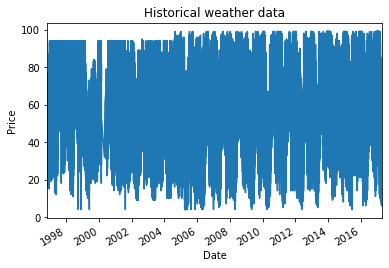

datetime_utc
1996-11-01 11:00:00    27.0
1996-11-01 12:00:00    32.0
1996-11-01 13:00:00    44.0
1996-11-01 14:00:00    41.0
1996-11-01 16:00:00    47.0
Name: humidity, dtype: float64
Null values: 0


In [35]:
#TODO: Choose a column from weather_data (solution uses humidity)

#YOUR CODE HERE
weather_data_one_col = weather_data['humidity']

#TODO: interpolate null values
#reference the appropriate code section from Part 3
weather_data_one_col.ffill(inplace=True)

#TODO: remove outliers
#reference the appropriate code section from Part 3
weather_data_one_col = weather_data_one_col[weather_data_one_col < 100]

#END YOUR CODE

weather_data_one_col.plot()
plt.xlabel('time')
plt.ylabel('Humidity')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Historical weather data')
plt.show()

print(weather_data_one_col.head())
print('Null values: %s' % str(weather_data_one_col.isnull().sum()))

Now, we need to resample the data to regular intervals as well as split the data into training and testing data.

<AxesSubplot:xlabel='datetime_utc'>

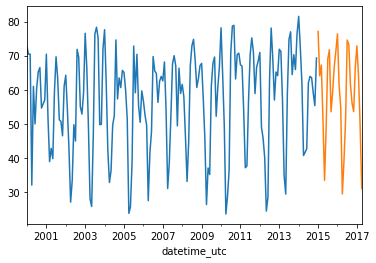

In [85]:
training_data = weather_data_one_col['2000':'2014'].resample('M').mean().fillna(method='pad')
testing_data = weather_data_one_col['2015':'2017'].resample('M').mean().fillna(method='pad')
training_data.plot()
testing_data.plot()

Now fill out the AR_Model class.

In [70]:
class AR_Model():
    def __init__(self, q):
        #TODO: initialize variables, for the AR Model (q, phi's)
        #Think: How many phi's do we need
        
        #YOUR CODE HERE
        self.phi = np.zeros(q)
        #END YOUR CODE
        
    def fit(self, data):
        #TODO: fit parameters to the data
        #steps:
        #create a data matrix (A), each row should have q previous observations
        #create a label vector (b), each element should be one observation
        #solve least squares Ax = b, x = phi's
        
        #return a vector of observations predicted from the fitted model, the same shape as data
        #multiply data matrix against the predicted model phi's and return the output vector
        
        #need to keep this for predicting
        self.data = data
        
        #YOUR CODE HERE
        data_mat = []
        label_vector = []
        for i in range(data.shape[0] - self.phi.shape[0]):
            data_mat.append(data[i:i+q])
            label_vector.append(data[i+q])
            
        data_mat = np.array(data_mat)
        label_vector = np.array(label_vector)
        
        w = np.linalg.lstsq(data_mat, label_vector)
        self.phi = w[0]
        
        #don't predict anything for first q observations as there are not q previous observations for the AR Model
        predicted = np.zeros(self.phi.shape[0])
        return np.hstack((predicted, data_mat @ self.phi))
        #END YOUR CODE
    
        
    def predict(self, n):
        #TODO: predict the next n observations given the fitted model
        
        #YOUR CODE HERE
        assert(len(self.data) > 0)
        data = list(np.copy(self.data))
        
        predictions = []
        for i in range(n):
            next_prediction = np.array(data[-q:]) @ self.phi
            data.append(next_prediction)
            predictions.append(next_prediction)
            
        return np.array(predictions)
        
        #END YOUR CODE
        

Edit and Run the following code to test your model and plot against both training and testing values.

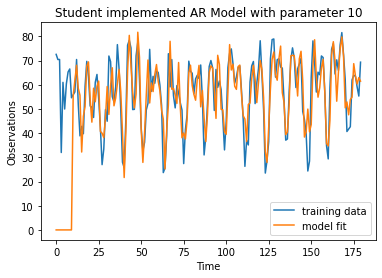

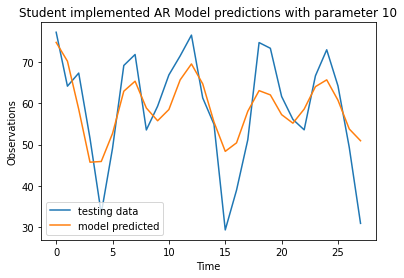

In [83]:
q = 10
arm = AR_Model(q)

model_fit_training = arm.fit(training_data)

plt.plot(training_data.values, label='training data')
plt.plot(model_fit_training, label='model fit')
plt.title('Student implemented AR Model with parameter %d' % q)
plt.xlabel('Time')
plt.ylabel('Observations')
plt.legend()
plt.show()


predicted = arm.predict(testing_data.shape[0])

plt.plot(testing_data.values, label='testing data')
plt.plot(predicted, label='model predicted')
plt.title('Student implemented AR Model predictions with parameter %d' % q)
plt.xlabel('Time')
plt.ylabel('Observations')
plt.legend()
plt.show()


Now, run the statsmodels implementation of an AR model on the same data. Yours should look similar.

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  180
Model:                    ARMA(10, 0)   Log Likelihood                -643.038
Method:                       css-mle   S.D. of innovations              8.525
Date:                Sun, 06 Dec 2020   AIC                           1310.076
Time:                        17:07:33   BIC                           1348.391
Sample:                             0   HQIC                          1325.611
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         56.9737      0.724     78.717      0.000      55.555      58.392
ar.L1.y        0.6030      0.070      8.559      0.000       0.465       0.741
ar.L2.y       -0.0025      0.082     -0.030      0.9

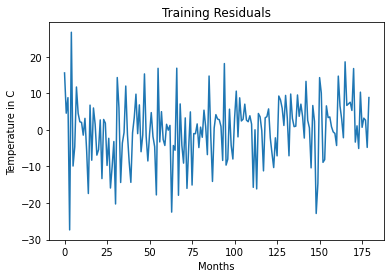

Mean squared training error: 76.40397554505093


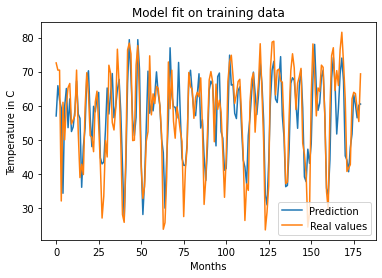

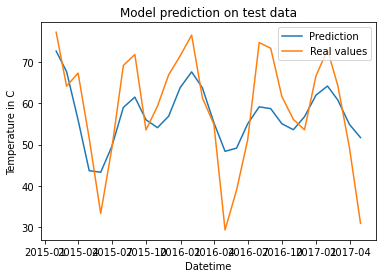

Mean squared testing error: 84.41936168873981


In [84]:
res = ARIMA(training_data.values, order=(q, 0, 0)).fit()
process_result(res)

Your code should run much faster than the statsmodels package. This is because we are implementing a very simple solver for the AR model parameters. If you would like to find out more about more complex and precise solvers, such as Maximum Likelihood Estimators, check out statsmodels opensource code hosted on github: https://github.com/statsmodels/statsmodels. Although we only wrote an AR solver in this part of the code, we derived the invertibility of MA models to AR models in the notes, so this solver could be applicable to any ARMA model. Supporting ARIMA models would require simply adding a differencing step.

## Part 6: Cool ARIMA models

There are some cool patterns that can be modeled using ARIMA. 
Do not use statsmodels.

1. Random Walk: ARIMA(0, 1, 0)
2. Random Walk with drift: ARIMA(0, 1, 0) w/ a constant


First: Derive the explicit formulation of each cool pattern as $X_t = $:

<span style="color:blue">The following are the dervations.</span>

Random Walk:
\begin{align*}
X_{t} = X_{t-1} + Z_{t}
\end{align*}

Random Walk with drift:
\begin{align*}
X_{t} = c + X_{t-1} + Z_{t}
\end{align*}

Implement the following functions.

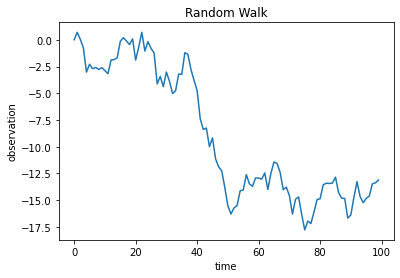

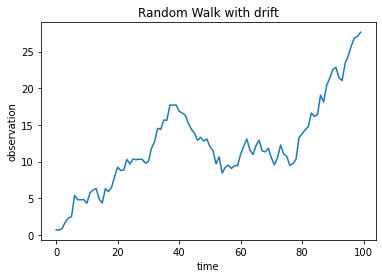

In [179]:
def random_walk(num_steps=100):
    state = 0
    ts = []
    
    for i in range(num_steps):
        state = np.random.normal(state, 1)
        ts.append(state)
        
    return ts

def random_walk_with_drift(num_steps=100, drift=0.4):
    state = 0
    ts = []
    
    for i in range(num_steps):
        state = np.random.normal(state + drift, 1)
        ts.append(state)
        
    return ts
    

random_walk_ts = random_walk()
random_walk_drift_ts = random_walk_with_drift()
dampled_holts_ts = dampled_holts()

plt.plot(random_walk_ts)
plt.title("Random Walk")
plt.xlabel("time")
plt.ylabel("observation")
plt.show()

plt.plot(random_walk_drift_ts)
plt.title("Random Walk with drift")
plt.xlabel("time")
plt.ylabel("observation")
plt.show()

### Observations

1. Run the above cell a few times. What does the Random Walk look like? What does the Random Walk with drift look like?

<span style="color:blue">The random walk looks like a random walk. The random walk with drift looks liike a random walk with an upwards drift, as expected.</span>

# Conclusions

This notebook provides an introduction to time series modeling, first exploring the concepts behind smoothing and stationarity, then using the open source statsmodels library to generate and fit ARIMA models, evaluating our ARIMA models, and finally exploring different patterns that can be modeled using ARIMA.